<a id="2"></a>
## <b>2 <span style='color:#B21010'>||</span> Import Necessaries</b>

In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


modules loaded


<a id="3"></a>
## <b>3 <span style='color:#B21010'>||</span> Setting the Enviroment</b>

In [2]:
train_data_path = '/kaggle/input/dataset/train'
test_data_path = '/kaggle/input/dataset/test'
valid_data_path = '/kaggle/input/dataset/val'

In [3]:
labels = os.listdir(valid_data_path)

Creating data working directory

In [4]:
data_path = '/kaggle/working/data'

if not os.path.exists(data_path):
    os.mkdir(data_path)
    print("Created Succesfulley!")
else:
    print("Folder already exist")

Created Succesfulley!


In [5]:
normal_data_path = '/kaggle/working/data/Normal'
oscc_data_path = '/kaggle/working/data/OSCC'

if not os.path.exists(normal_data_path):
    os.mkdir(normal_data_path)
    print("Created Succesfulley!")
else:
    print("Folder already exist")
    
if not os.path.exists(oscc_data_path):
    os.mkdir(oscc_data_path)
    print("Created Succesfulley!")
else:
    print("Folder already exist")

Created Succesfulley!
Created Succesfulley!


Moving all the images to the data working directory

In [6]:
def move_data(d_path, saved_path):
    for i in labels:
        images = os.listdir(d_path + '/' + i)
        for j in images:
            path = d_path +'/' + i
            img = cv2.imread(path + '/' + j)
            s_path = saved_path + '/' + i + '/' + j
            cv2.imwrite(s_path, img)

In [7]:
move_data(train_data_path, data_path)

In [8]:
norm_path = len(os.listdir(data_path + '/' + labels[0]))
oscc_path = len(os.listdir(data_path + '/' + labels[1]))
print(norm_path+oscc_path)

4946


In [9]:
move_data(test_data_path, data_path)

In [10]:
norm_path = len(os.listdir(data_path + '/' + labels[0]))
oscc_path = len(os.listdir(data_path + '/' + labels[1]))
print(norm_path+oscc_path)

5072


In [11]:
move_data(valid_data_path, data_path)

In [12]:
norm_path = len(os.listdir(data_path + '/' + labels[0]))
oscc_path = len(os.listdir(data_path + '/' + labels[1]))
print(norm_path+oscc_path)

5192


<a id="4"></a>
## <b>4 <span style='color:#B21010'>||</span> EDA</b>

<a id="4.1"></a>
### <b>4.1 <span style='color:#B21010'>||</span> Define data path and dataset name</b>

In [13]:
data_dir = '/kaggle/working/data'
ds_name = 'Oral Cancer'

<a id="4.2"></a>
### <b>4.2 <span style='color:#B21010'>||</span> Create Dataframe for the dataset</b>

In [14]:
# Generate data paths with labels

def generate_data_paths(data_dir):
    
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [15]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

In [16]:
df.head()

filepaths  labels
0     /kaggle/working/data/Normal/aug_56_7116.jpg  Normal
1  /kaggle/working/data/Normal/Normal_100x_85.jpg  Normal
2    /kaggle/working/data/Normal/aug_229_5671.jpg  Normal
3  /kaggle/working/data/Normal/Normal_400x_17.jpg  Normal
4    /kaggle/working/data/Normal/aug_145_3113.jpg  Normal

<a id="4.3"></a>
### <b>4.3 <span style='color:#B21010'>||</span> Display Number of Examples in the dataset</b>

In [17]:
def num_of_examples(df, name='df'):
    print(f"The {name} dataset has {df.shape[0]} images.")
    
num_of_examples(df, ds_name)

The Oral Cancer dataset has 5192 images.


<a id="4.4"></a>
### <b>4.4 <span style='color:#B21010'>||</span> Display Number of Classes in the dataset</b>

In [18]:
def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")
    
num_of_classes(df, ds_name)

The Oral Cancer dataset has 2 classes


<a id="4.5"></a>
### <b>4.5 <span style='color:#B21010'>||</span> Display count of images in each class of the dataset</b>

In [19]:
def classes_count(df, name='df'):
    
    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)
        
classes_count(df, ds_name)

The Oral Cancer dataset has: 

Class 'Normal' has 2494 images
----------------------------------------------------------------------
Class 'OSCC' has 2698 images
----------------------------------------------------------------------


<a id="4.6"></a>
### <b>4.6 <span style='color:#B21010'>||</span> Visualize Each Class in the dataset</b>

In [20]:
def cat_summary_with_graph(dataframe, col_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=dataframe[col_name].value_counts().values.tolist(),
                         x=[str(i) for i in dataframe[col_name].value_counts().index],
                         text=dataframe[col_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=col_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=colors,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=dataframe[col_name].value_counts().keys(),
                         values=dataframe[col_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=col_name,
                         marker=dict(colors=colors)),
                  row=1, col=2)

    fig.update_layout(title={'text': col_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)
    
    
colors = ['#494BD3', '#E28AE2', '#F1F481', '#79DB80', '#DF5F5F',
              '#69DADE', '#C2E37D', '#E26580', '#D39F49', '#B96FE3']

cat_summary_with_graph(df,'labels')

**The data is Balanced**

<a id="4.7"></a>
### <b>4.7 <span style='color:#B21010'>||</span> Check Null values in the dataframe</b>

In [21]:
def check_null_values(df, name='df'):
    
    num_null_vals = sum(df.isnull().sum().values)
    
    if not num_null_vals:
        print(f"The {name} dataset has no null values")
    
    else:
        print(f"The {name} dataset has {num_null_vals} null values")
        print('-'*70)
        print('Total null values in each column:\n')
        print(df.isnull().sum())
        

check_null_values(df, ds_name)

The Oral Cancer dataset has no null values


<a id="4.8"></a>
### <b>4.8 <span style='color:#B21010'>||</span> Visualize Null values</b>

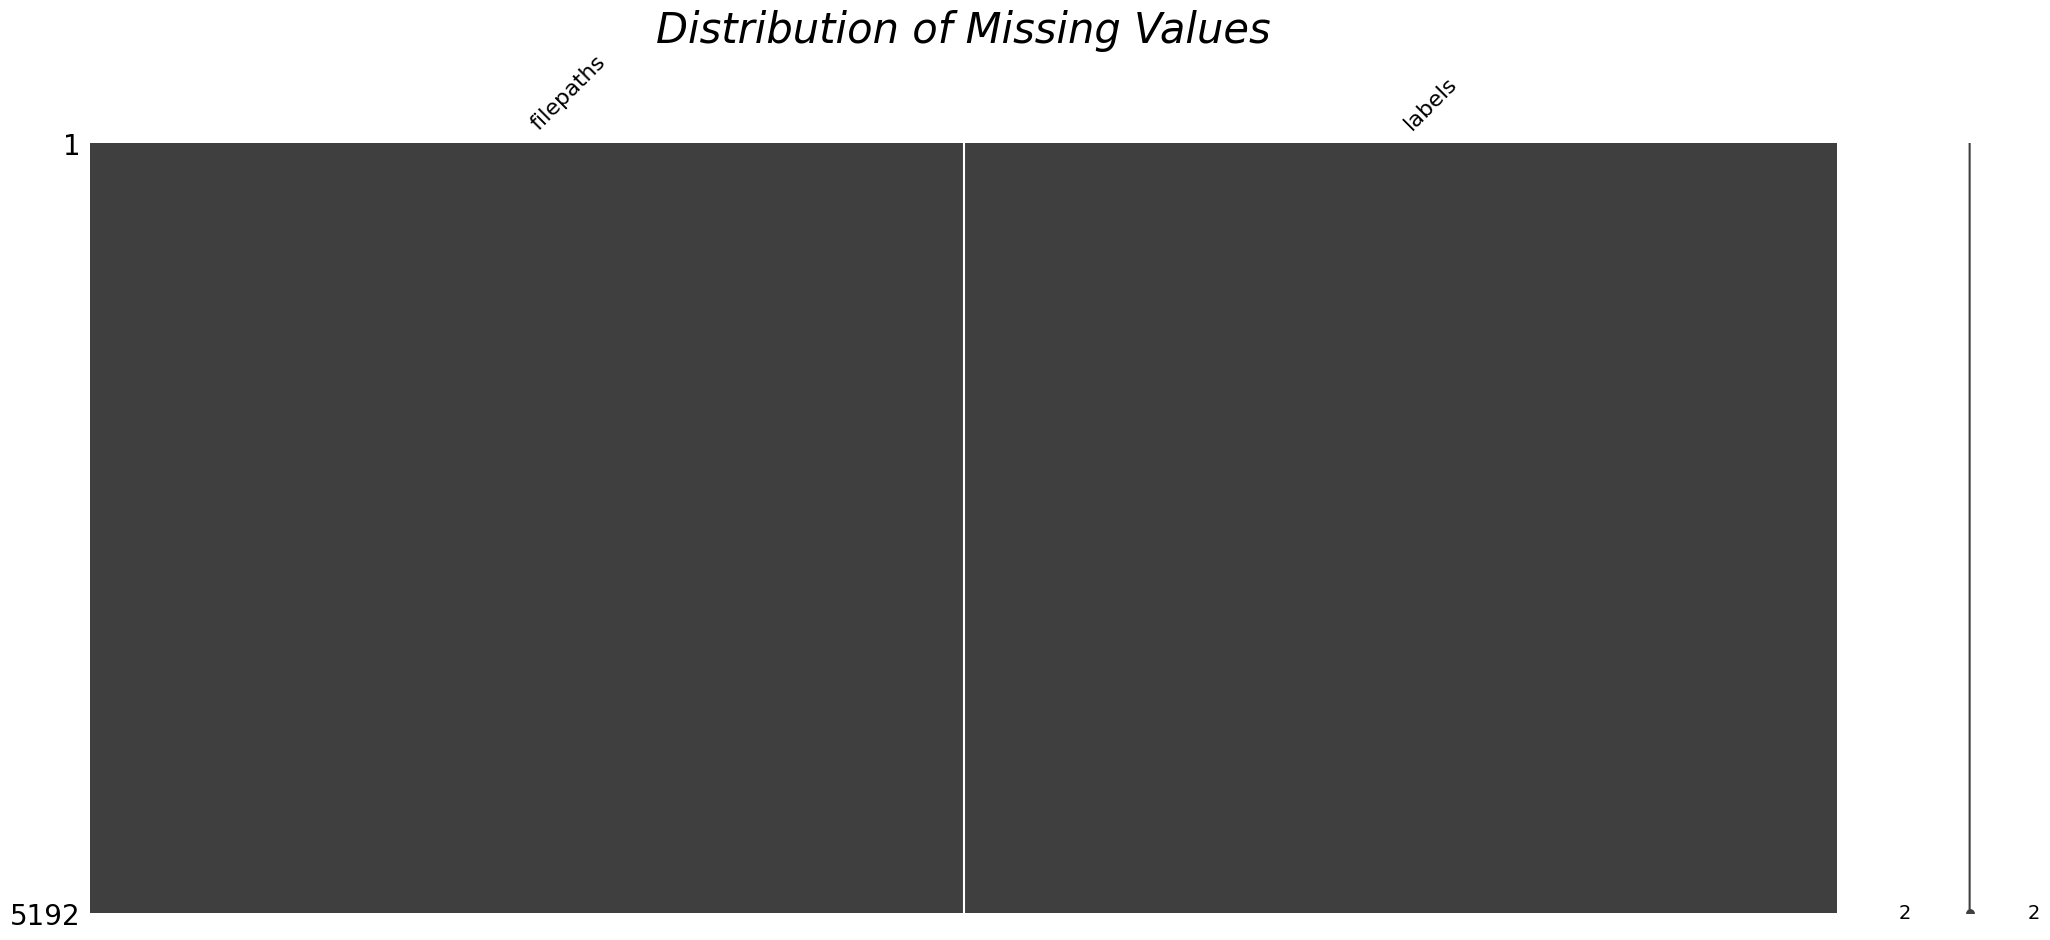

In [22]:
msno.matrix(df)
plt.title('Distribution of Missing Values', fontsize=30, fontstyle='oblique');

<a id="5"></a>
## <b>5 <span style='color:#B21010'>||</span>Split dataframe into train, valid, and test</b>

In [23]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [24]:
num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)

The Training Oral Cancer dataset has 2 classes
The Validation Oral Cancer dataset has 2 classes
The Testing Oral Cancer dataset has 2 classes


In [25]:
classes_count(train_df, 'Training '+ds_name)

The Training Oral Cancer dataset has: 

Class 'Normal' has 1775 images
----------------------------------------------------------------------
Class 'OSCC' has 1859 images
----------------------------------------------------------------------


In [26]:
classes_count(valid_df, 'Validation '+ds_name)

The Validation Oral Cancer dataset has: 

Class 'OSCC' has 420 images
----------------------------------------------------------------------
Class 'Normal' has 359 images
----------------------------------------------------------------------


In [27]:
classes_count(test_df, 'Testing '+ds_name)

The Testing Oral Cancer dataset has: 

Class 'Normal' has 360 images
----------------------------------------------------------------------
Class 'OSCC' has 419 images
----------------------------------------------------------------------


<a id="6"></a>
## <b>6 <span style='color:#B21010'>||</span>Create Image Data Generator</b>

In [28]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           horizontal_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe(train_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df, 
                                      x_col= 'filepaths', 
                                      y_col= 'labels', 
                                      target_size= img_size, 
                                      class_mode= 'categorical',
                                      color_mode= 'rgb', 
                                      shuffle= False, 
                                      batch_size= test_batch_size)

Found 3634 validated image filenames belonging to 2 classes.
Found 779 validated image filenames belonging to 2 classes.
Found 779 validated image filenames belonging to 2 classes.


<a id="7"></a>
## <b>7 <span style='color:#B21010'>||</span>Visualize Training dataset</b>

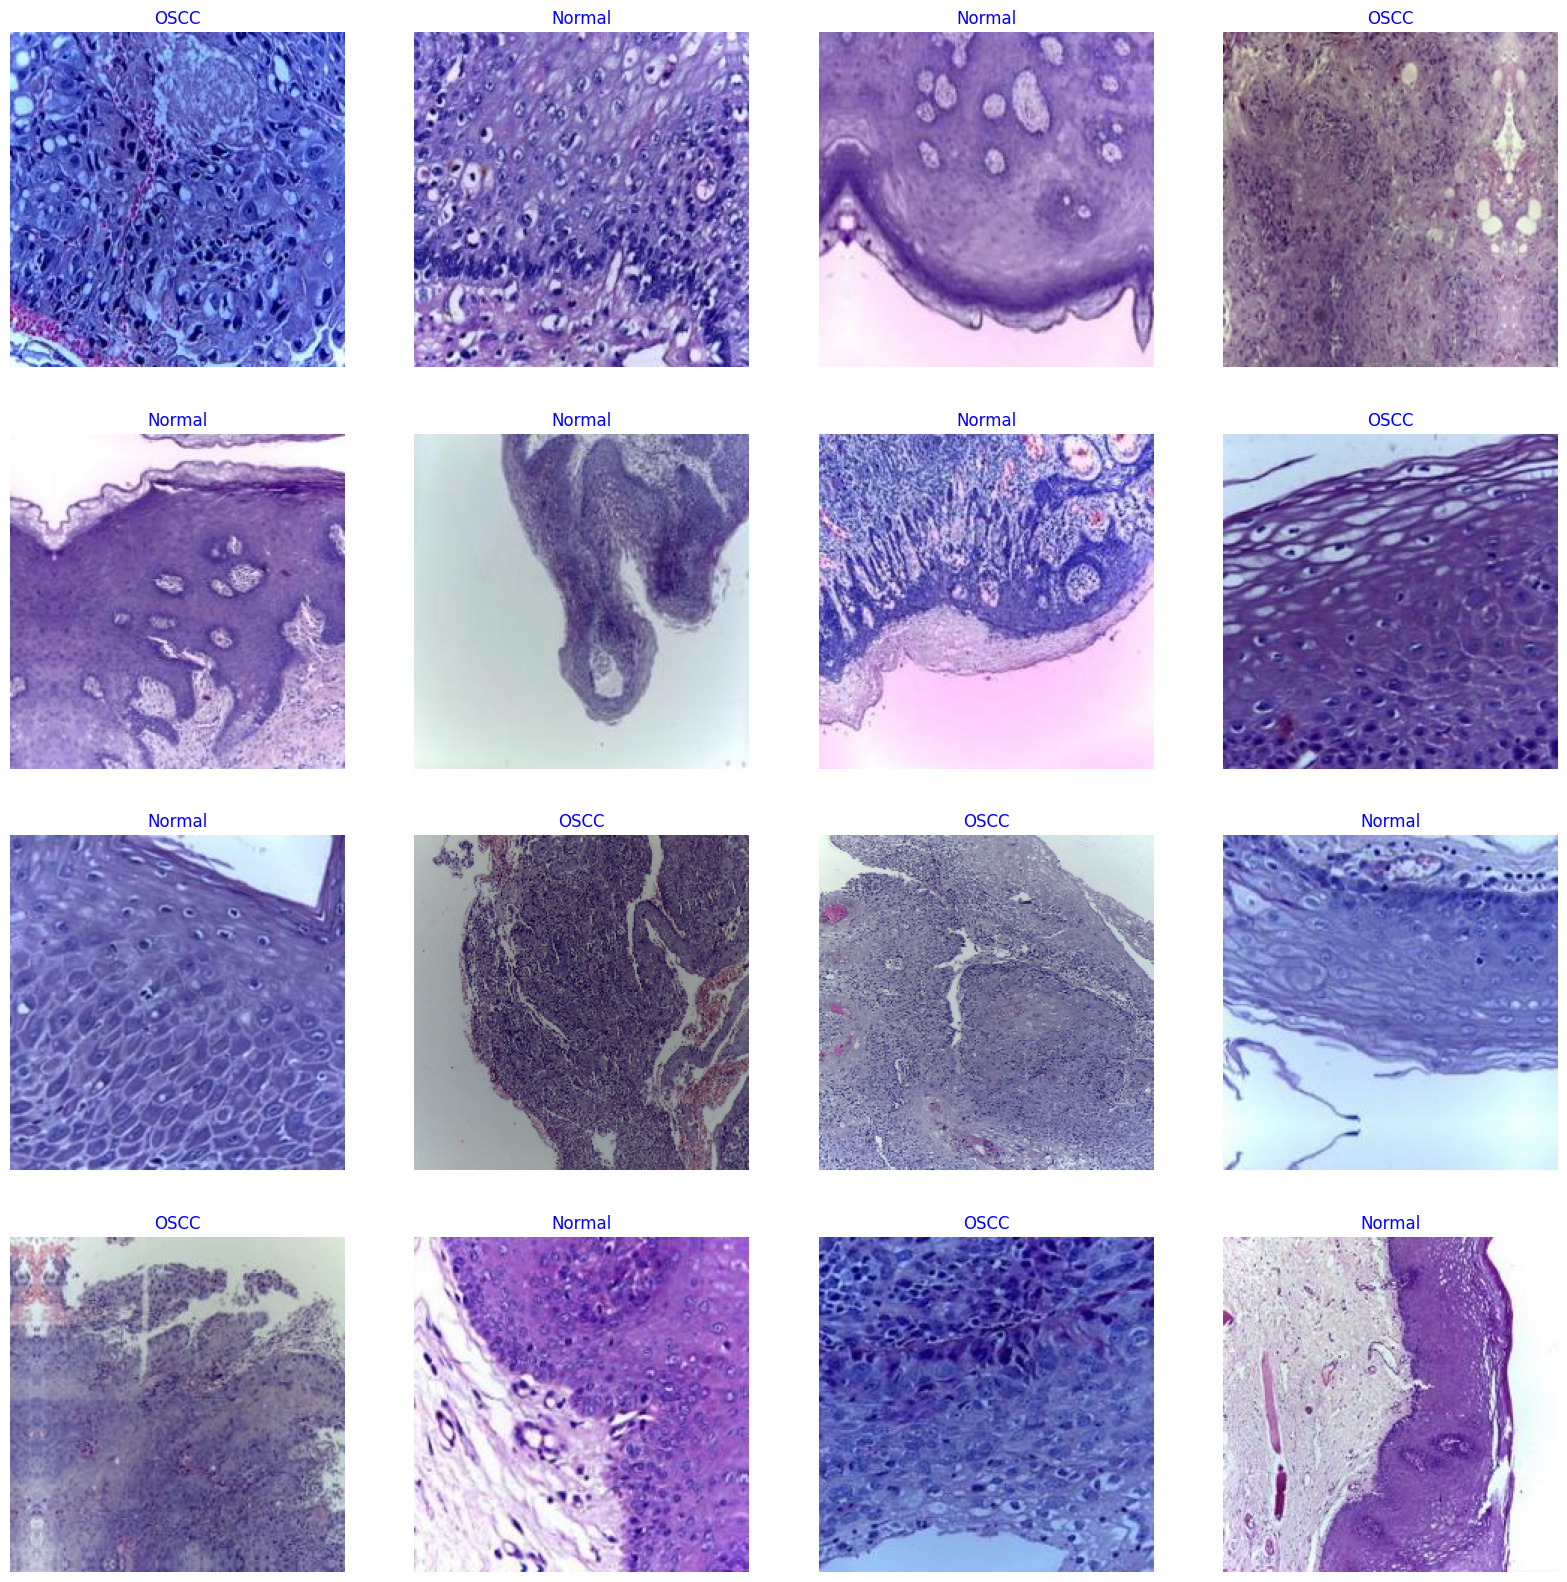

In [29]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
    
plt.show()

<a id="8"></a>
## <b>8 <span style='color:#B21010'>||</span>Model Structure</b>

<a id="8.1"></a>
### <b>8.1 <span style='color:#B21010'>||</span>Generic Model Creation</b>

In [30]:
#Soft Attention

from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
import tensorflow as tf
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,GlobalAveragePooling2D,BatchNormalization,Dropout
from tensorflow.keras import Model

class SoftAttention(Layer):
    def __init__(self,ch,m,concat_with_x=False,aggregate=False,**kwargs):
        self.channels=int(ch)
        self.multiheads = m
        self.aggregate_channels = aggregate
        self.concat_input_with_scaled = concat_with_x

        
        super(SoftAttention,self).__init__(**kwargs)

    def build(self,input_shape):

        self.i_shape = input_shape

        kernel_shape_conv3d = (self.channels, 3, 3) + (1, self.multiheads) # DHWC
    
        self.out_attention_maps_shape = input_shape[0:1]+(self.multiheads,)+input_shape[1:-1]
        
        if self.aggregate_channels==False:

            self.out_features_shape = input_shape[:-1]+(input_shape[-1]+(input_shape[-1]*self.multiheads),)
        else:
            if self.concat_input_with_scaled:
                self.out_features_shape = input_shape[:-1]+(input_shape[-1]*2,)
            else:
                self.out_features_shape = input_shape
        

        self.kernel_conv3d = self.add_weight(shape=kernel_shape_conv3d,
                                        initializer='he_uniform',
                                        name='kernel_conv3d')
        self.bias_conv3d = self.add_weight(shape=(self.multiheads,),
                                      initializer='zeros',
                                      name='bias_conv3d')

        super(SoftAttention, self).build(input_shape)

    def call(self, x):

        exp_x = K.expand_dims(x,axis=-1)

        c3d = K.conv3d(exp_x,
                     kernel=self.kernel_conv3d,
                     strides=(1,1,self.i_shape[-1]), padding='same', data_format='channels_last')
        conv3d = K.bias_add(c3d,
                        self.bias_conv3d)
        conv3d = kl.Activation('relu')(conv3d)

        conv3d = K.permute_dimensions(conv3d,pattern=(0,4,1,2,3))

        
        conv3d = K.squeeze(conv3d, axis=-1)
        conv3d = K.reshape(conv3d,shape=(-1, self.multiheads ,self.i_shape[1]*self.i_shape[2]))

        softmax_alpha = K.softmax(conv3d, axis=-1) 
        softmax_alpha = kl.Reshape(target_shape=(self.multiheads, self.i_shape[1],self.i_shape[2]))(softmax_alpha)

        
        if self.aggregate_channels==False:
            exp_softmax_alpha = K.expand_dims(softmax_alpha, axis=-1)       
            exp_softmax_alpha = K.permute_dimensions(exp_softmax_alpha,pattern=(0,2,3,1,4))
   
            x_exp = K.expand_dims(x,axis=-2)
   
            u = kl.Multiply()([exp_softmax_alpha, x_exp])   
  
            u = kl.Reshape(target_shape=(self.i_shape[1],self.i_shape[2],u.shape[-1]*u.shape[-2]))(u)

        else:
            exp_softmax_alpha = K.permute_dimensions(softmax_alpha,pattern=(0,2,3,1))

            exp_softmax_alpha = K.sum(exp_softmax_alpha,axis=-1)

            exp_softmax_alpha = K.expand_dims(exp_softmax_alpha, axis=-1)

            u = kl.Multiply()([exp_softmax_alpha, x])   

        if self.concat_input_with_scaled:
            o = kl.Concatenate(axis=-1)([u,x])
        else:
            o = u
        
        return [o, softmax_alpha]

    def compute_output_shape(self, input_shape): 
        return [self.out_features_shape, self.out_attention_maps_shape]

    
    def get_config(self):
        return super(SoftAttention,self).get_config()

resnet = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
)

# Exclude the last 3 layers of the model.
conv = resnet.layers[-3].output

attention_layer,map2 = SoftAttention(aggregate=True,m=16,concat_with_x=False,ch=int(conv.shape[-1]),name='soft_attention')(conv)
attention_layer=(MaxPooling2D(pool_size=(2, 2),padding="same")(attention_layer))
conv=(MaxPooling2D(pool_size=(2, 2),padding="same")(conv))

conv = concatenate([conv,attention_layer])
conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)

output = GlobalAveragePooling2D()(conv)
output = Dense(2, activation='softmax')(output)
model = Model(inputs=resnet.input, outputs=output)

102967424/102967424 [==============================] - 0s 0us/step


In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

<a id="8.2"></a>
### <b>8.2 <span style='color:#B21010'>||</span>Define Early Stop</b>

In [32]:
# prepare usefull callbacks
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("oral.h5", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)
lr_reducer = ReduceLROnPlateau(monitor='val_acc', factor=0.2, patience=7, min_lr=10e-7, epsilon=0.01, verbose=1)
early_stopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=100, verbose=1)
callbacks= [lr_reducer, checkpoint, early_stopper]

In [33]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

<a id="8.3"></a>
### <b>8.3 <span style='color:#B21010'>||</span>Train Model</b>

In [34]:
batch_size = 128   # set batch size for training
epochs = 100   # number of all epochs in training

history = model.fit(x=train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= valid_gen, 
                    validation_steps= None,
                    shuffle= False,callbacks=callbacks,
                    batch_size= batch_size)

Epoch 1/100


2025-07-26 08:43:04.734721: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


228/228 [==============================] - ETA: 0s - loss: 0.4954 - accuracy: 0.7713
Epoch 1: val_accuracy improved from -inf to 0.84339, saving model to oral.h5
228/228 [==============================] - 186s 299ms/step - loss: 0.4954 - accuracy: 0.7713 - val_loss: 0.3738 - val_accuracy: 0.8434 - lr: 0.0010
Epoch 2/100
228/228 [==============================] - ETA: 0s - loss: 0.2451 - accuracy: 0.9020
Epoch 2: val_accuracy improved from 0.84339 to 0.88703, saving model to oral.h5
228/228 [==============================] - 56s 246ms/step - loss: 0.2451 - accuracy: 0.9020 - val_loss: 0.2858 - val_accuracy: 0.8870 - lr: 0.0010
Epoch 3/100
228/228 [==============================] - ETA: 0s - loss: 0.1761 - accuracy: 0.9323
Epoch 3: val_accuracy improved from 0.88703 to 0.92555, saving model to oral.h5
228/228 [==============================] - 56s 246ms/step - loss: 0.1761 - accuracy: 0.9323 - val_loss: 0.1939 - val_accuracy: 0.9255 - lr: 0.0010
Epoch 4/100
228/228 [=====================

<a id="9"></a>
## <b>9 <span style='color:#B21010'>||</span>Evaluate Model</b>

In [35]:
accuracy_score = model.evaluate(test_gen)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])

19/19 [==============================] - 6s 258ms/step - loss: 0.1863 - accuracy: 0.9756
[0.1863052248954773, 0.9756097793579102]
Accuracy: 97.5610%
Loss:  0.1863052248954773


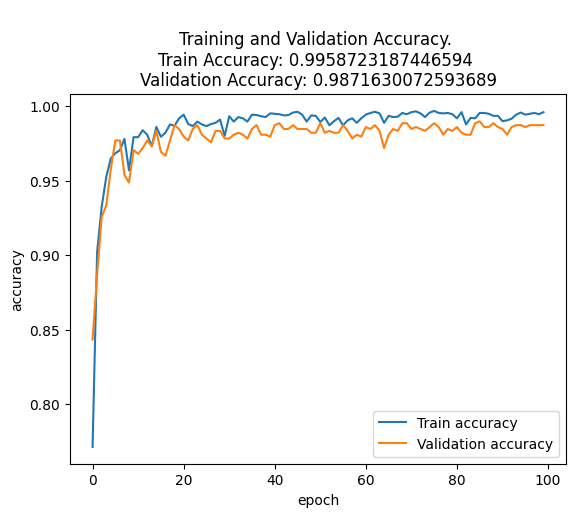

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {(str(acc[-1]))} \nValidation Accuracy: {str(val_acc[-1])}')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

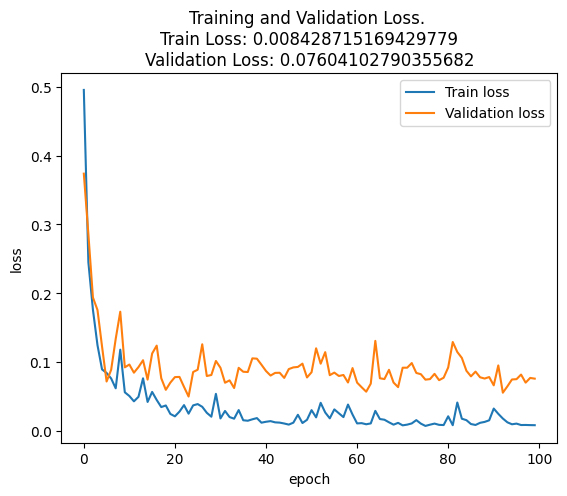

In [ ]:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plt.show()

In [38]:
from sklearn.metrics import classification_report

labels = ['Normal', 'OSCC']

preds = model.predict(test_gen, verbose=1)
preds_labels = np.argmax(preds, axis=1)
gr_th = test_gen.classes

print(classification_report(gr_th, preds_labels, target_names=labels))

19/19 [==============================] - 6s 259ms/step
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.97       360
        OSCC       0.98      0.97      0.98       419

    accuracy                           0.98       779
   macro avg       0.98      0.98      0.98       779
weighted avg       0.98      0.98      0.98       779



Confusion matrix, without normalization


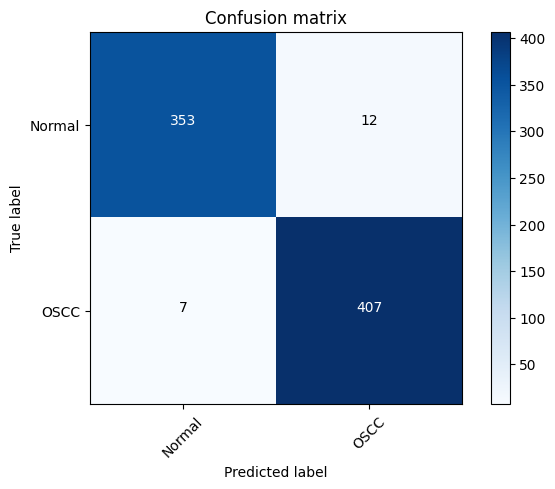

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(preds_labels, gr_th)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels, title='Confusion matrix')
plt.show()

In [40]:
import os
import numpy as np
import sys, math
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, cohen_kappa_score, confusion_matrix

cm = confusion_matrix(preds_labels, gr_th)
print("Confusion Matrix:\n", cm)

# Convert confusion matrix to a list if necessary
cm = cm.tolist()
n_classes = 2
cm = np.array(cm)

for c in range(n_classes):
    tp = cm[c,c]
    fp = sum(cm[:,c]) - cm[c,c]
    fn = sum(cm[c,:]) - cm[c,c]
    tn = sum(np.delete(sum(cm)-cm[c,:],c))

    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    f1_score = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) != 0 else 0

print("TP: ", tp)
print("FP: ", fp)
print("FN: ", fn)
print("TN: ", tn)

precision = tp / (tp + fp) if (tp + fp) != 0 else 0
print(f"Precision: {precision:.4f}")

sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
print(f"Sensitivity: {sensitivity:.4f}")

specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
print(f"Specificity: {specificity:.4f}")

accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0
print(f"Accuracy: {accuracy:.4f}")

# Safeguard for MCC calculation
epsilon = 1e-10  # Small value to prevent division by zero
denominator = math.sqrt((tp + fp + epsilon) * (tp + fn + epsilon) * (tn + fp + epsilon) * (tn + fn + epsilon))
if denominator == 0:
    mcc = 0
else:
    mcc = float(tp * tn - fp * fn) / denominator
print(f"MCC: {mcc:.4f}")

f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 0
print(f"F1 Score: {f1:.4f}")

kappa = cohen_kappa_score(preds_labels, gr_th)
print(f"Kappa Score: {kappa:.4f}")

roc_auc = roc_auc_score(preds_labels, gr_th, multi_class="ovo", average="weighted")
print(f"ROC-AUC Score: {roc_auc:.3f}")

Confusion Matrix:
 [[353  12]
 [  7 407]]
TP:  407
FP:  12
FN:  7
TN:  353
Precision: 0.9714
Sensitivity: 0.9831
Specificity: 0.9671
Accuracy: 0.9756
MCC: 0.9511
F1 Score: 0.9772
Kappa Score: 0.9510
ROC-AUC Score: 0.975


19/19 [==============================] - 5s 279ms/step


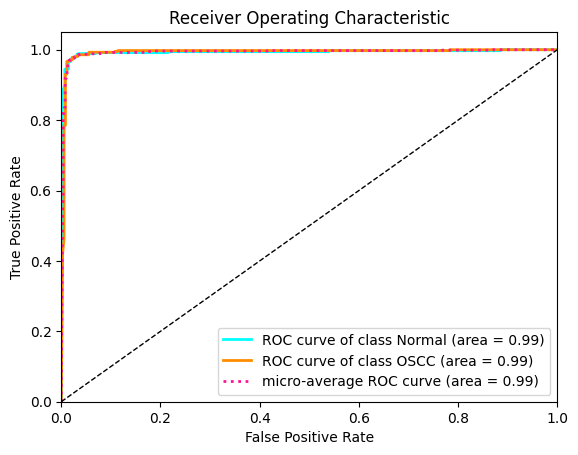

In [ ]:
from tensorflow.keras.utils import to_categorical

# Predict the probabilities for the test set
y_score = model.predict(test_gen)

# Convert `test_data.classes` to a flat array and then one-hot encode it
y_test = np.array(test_gen.classes).ravel()  # Ensure y_test is a 1D array
y_test = to_categorical(y_test, num_classes=2)  # One-hot encode to shape (2000, 2)

# Calculate ROC curves and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):  # Loop over each class (0 and 1)
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure()

colors = ['aqua', 'darkorange']
for i in range(2):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(labels[i], roc_auc[i]))

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=2,
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()